In [40]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
from tqdm import tqdm
from sklearn.utils import class_weight
import keras_utils

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
import librosa
import os
import soundfile as sf
import tarfile
import shutil

from sklearn.metrics import precision_recall_fscore_support, accuracy_score


In [41]:
devices = tf.config.list_physical_devices()
print(devices)
print(tf.test.is_gpu_available())
# tf.debugging.set_log_device_placement(True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


2024-02-18 00:33:46.428324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-18 00:33:46.428354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [42]:
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

In [43]:
DATA_DIR = Path("/Users/elnur/Desktop/HDA/project/speech_commands_v0.02")
SAMPLE_RATE = 16000 # Hz
FRAME_LENGTH_MS = 25 # ms
FRAME_HOP_MS = 10 # 10 ms
FRAMES_BEFORE = 23 
FRAMES_AFTER = 8
N_MELS = 40
frame_length_samples = int(SAMPLE_RATE * FRAME_LENGTH_MS / 1000)
frame_hop_samples = int(SAMPLE_RATE * FRAME_HOP_MS / 1000)

keywords = ["_silence_", "_unknown_", "down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes"]


# Data

## Extract data

In [5]:
cwd = os. getcwd()
DATASET_PATH = cwd + '/speech_commands_v0.02'
data_dir = Path(DATASET_PATH)

if data_dir.exists():
    shutil.rmtree(DATASET_PATH, ignore_errors=True)
    tar_path = '/Users/elnur/Desktop/HDA/project/speech_commands_v0.02.tar'
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(DATASET_PATH)
    print("preprocessed data is removed and original data is extracted")
else:
    tar_path = '/Users/elnur/Desktop/HDA/project/speech_commands_v0.02.tar'
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(DATASET_PATH)
    print("data is extracted")
 

preprocessed data is removed and original data is extracted


## Data preprocessing

### Detect low quality audios
- This is not used for our training results, however, parameters (mean/std) are highly depend on the given data and should be found with tuning/trying many audios. It would so likely improve the results if we remove low quality audios but we will lose some data in that case.

- Some functions are provided in Data Processing section of the Notebook which I believe that is a better option to clean bad audios and then use them instead of just removing them. Those functions also aren't applied as it ended as worsening the results when all applied. They require better investigation of datas and finding right parameters for the corresponding functions to apply which would be the best approach.

In [91]:
def is_bad_audio(filepath):
    audio_file, sr = librosa.load(filepath, sr=SAMPLE_RATE)
    # audio_file = audio_file.numpy()

    features = librosa.feature.mfcc(y=audio_file)
    mean_frequencies = np.mean(features.T, axis=0)
    s = sum(mean_frequencies)
    t = np.std(mean_frequencies)
    if t < 0.01:
        # silent
        return True
    elif (s > 20 and t < 0.2):
        # noisy
        return True
    elif (s > 30 and t > 1):
        # distorted
        return True
    return False


In [103]:
# audio_signal = librosa.load('/Users/elnur/Desktop/HDA/project/speech_commands_v0.02/test_data/_silence_/time_shifting_speed_tuning_mix_bg_noise_pink_noise_chunk624000.wav')
y, sr = librosa.load('/Users/elnur/Desktop/HDA/project/speech_commands_v0.02/train_data/_unknown_/c0c701f1_nohash_0_wow.wav', sr=SAMPLE_RATE)

display.display(display.Audio(y, rate=16000))


In [ ]:
output_file = "bad_audio_files.txt"

with open(output_file, "w") as f:
    for root, dirs, files in os.walk(DATA_DIR):
        for filename in files:
            if filename.endswith(".wav"):
                file_path = os.path.join(root, filename)
                if is_bad_audio(file_path):
                    # Write the filename to the text file
                    f.write(file_path + "\n")

### Some data augmentation techniques: 
    -   Time shifting
    -   Speed tuning
    -   Mix background noise & volume tuning
    -   And some other minor augmentations which can also be used
    -   After augmentation, resample the audio to have the same length and sampling rate

- Data augmentation is applied only to background noise (_silence_ class) as it was heavily less occured than others. However, KWS is data hungry task, therefore, in case of having enough computational power using Augmentation is suggested.

In [6]:
def resample_audio(data, target_sr=SAMPLE_RATE, target_duration=1.0):

    # If the resampled audio is shorter than the target duration, pad it with zeros
    if len(data) < target_duration * target_sr:
        pad_length = int(target_duration * target_sr) - len(data)
        data = np.pad(data, (0, pad_length), 'constant')

    # If the resampled audio is longer than the target duration, slice it
    if len(data) > target_duration * target_sr:
        data = data[:int(target_duration * target_sr)]

    
    return data


In [7]:
# slightly shift the starting point of the audio, then pad it to original length.
def time_shifting(data, sampling_rate = SAMPLE_RATE, shift_max = 0.2, shift_direction = 'both'):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return resample_audio(augmented_data)

In [8]:
# slightly change the speed of the audio, then pad or slice it.
def speed_tuning(data, sr = SAMPLE_RATE):
        speed_rate = np.random.uniform(0.5,2)
        data = librosa.effects.time_stretch(data, rate=speed_rate)
        return resample_audio(data)


In [9]:
def mix_bg_noise(wav, sr = SAMPLE_RATE, dir_path = '/Users/elnur/Desktop/HDA/project/speech_commands_v0.02/_background_noise_/', printer = False):
    bg_files = os.listdir(dir_path)
    bg_files.remove('README.md')
    chosen_bg_file = bg_files[np.random.randint(len(bg_files))]
    bg, sr = librosa.load(dir_path+chosen_bg_file)
    if printer == True:
        print(chosen_bg_file)

    start_ = np.random.randint(bg.shape[0]-SAMPLE_RATE)
    bg_slice = bg[start_ : start_+SAMPLE_RATE]
    wav = resample_audio(wav) # in case of mixing with other augmentations
    # input wav can need resampling.
    wav_with_bg = wav * np.random.uniform(0.8, 1.2) + \
                bg_slice * np.random.uniform(0.2, 0.4)
    return resample_audio(wav_with_bg)

In [10]:
def add_noise(data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return resample_audio(data_noise)

def pitch(data, sr = SAMPLE_RATE):
    pitch_factor = np.random.uniform(2, 10)
    return resample_audio(librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor))

In [11]:
augmentation_functions = [speed_tuning, pitch, time_shifting, mix_bg_noise]

In [12]:
def apply_random_augmentation(file_path, printer = False):
    num_functions = np.random.randint(1,5)
    np.random.shuffle(augmentation_functions)
    selected_functions = np.random.choice(augmentation_functions, num_functions, replace=False)
    function_names = [func.__name__ for func in selected_functions]
    if printer == True:
        print(function_names)
    x , sr = librosa.load(file_path, sr=SAMPLE_RATE)
    for func in selected_functions:
        if func == mix_bg_noise:
            data = func(x, SAMPLE_RATE, printer = printer)
        else:
            data = func(x, SAMPLE_RATE)

    return data, function_names

['time_shifting', 'mix_bg_noise', 'pitch']
dude_miaowing.wav


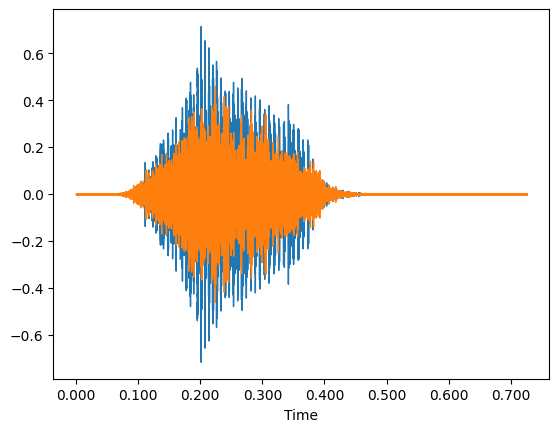

In [109]:
file_path='/Users/elnur/Desktop/HDA/project/speech_commands_v0.02/zero/0a2b400e_nohash_0.wav'
x , sr = librosa.load(file_path, sr=SAMPLE_RATE)
librosa.display.waveshow(x)
x, function_names = apply_random_augmentation(file_path, printer = True)
librosa.display.waveshow(x)
display.Audio(x, rate=SAMPLE_RATE)


### Preprocess background noise files
- Split each audio file in the folder into smaller chunks

In [13]:

def split_background_noise_files(folder_path, duration):
    # Get a list of all audio files in the folder
    audio_files = [file for file in os.listdir(folder_path) if file.endswith(".wav")]

    # Iterate over the audio files
    for audio_file in audio_files:
        # Construct the full path of the audio file
        audio_path = os.path.join(folder_path, audio_file)

        # Load the background noise segment
        audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

        # Calculate the number of samples in the desired duration
        desired_samples = int(sr * duration)

        # Calculate the step size for sliding the window
        hop_length = desired_samples // 2

        # Slide the window over the background noise segment
        for i in range(0, len(audio) - desired_samples + 1, hop_length):
            # Extract the chunk within the current window
            chunk = audio[i:i + desired_samples]
            # Apply window function to the chunk(hanning)
            windowed_chunk = chunk * np.hanning(len(chunk))
            # windowed_chunk = chunk * np.blackman(len(chunk))
            # Construct the output file name
            output_file = audio_file.replace(".wav", f"_chunk{i}.wav")

            # Construct the full output file path
            output_path = os.path.join(folder_path, output_file)

            # Save the chunk as a separate audio file
            sf.write(output_path, windowed_chunk, sr)

        os.remove(audio_path)
# Example usage
background_path = '/Users/elnur/Desktop/HDA/project/speech_commands_v0.02/_background_noise_'
duration = 1.0  # Desired duration of each segmented chunk in seconds

# Split each audio file in the folder into smaller chunks
split_background_noise_files(background_path, duration)


#### Augment background noise
    For every file, augmentation is applied 6 times

In [14]:
def augment_background_noise(folder_path):

    # list all files in the directory
    audio_files = [file for file in os.listdir(folder_path) if file.endswith(".wav")]

    # loop through each file and apply augmentation 6 times
    for file_name in audio_files:
        file_path = os.path.join(folder_path, file_name)
        
        # apply augmentation 6 times
        for i in range(6):
            x, function_names = apply_random_augmentation(file_path)
            applied_augmentations = "_".join(function_names)
            augmented_file_path = os.path.join(folder_path, f"{applied_augmentations}_{file_name}")

            # check if the file already exists
            while os.path.exists(augmented_file_path):
                # if file exists, generate a new augmented_file_path
                x, function_names = apply_random_augmentation(file_path)
                applied_augmentations = "_".join(function_names)
                augmented_file_path = os.path.join(folder_path, f"{applied_augmentations}_{file_name}")


            sf.write(augmented_file_path, x, SAMPLE_RATE)


    print("Augmentation complete.")

In [15]:
augment_background_noise(background_path)

Augmentation complete.


### Prepare the data. Split into train-val-test

In [16]:
train_dir = os.path.join(DATA_DIR, 'train_data')
test_dir = os.path.join(DATA_DIR, 'test_data')
val_dir = os.path.join(DATA_DIR, 'validation_data')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Load testing and validation lists
with open(DATA_DIR / "testing_list.txt") as f:
    testing_list = list(map(lambda x: DATA_DIR / Path(x), f.read().splitlines()))

with open(DATA_DIR / "validation_list.txt") as f:
    validation_list = list(map(lambda x: DATA_DIR / Path(x), f.read().splitlines()))

# Create subdirectories in train-test-val directories

for keyword in keywords:
    os.makedirs(os.path.join(train_dir, keyword), exist_ok=True)
    os.makedirs(os.path.join(test_dir, keyword), exist_ok=True)
    os.makedirs(os.path.join(val_dir, keyword), exist_ok=True)



In [17]:
def split_core(folder_name):
    label = folder_name
    folder_path = Path(os.path.join(DATA_DIR, folder_name))
    wav_filenames = [fn for fn in list(folder_path.glob("*.wav"))]

    for file_name in wav_filenames:
        if file_name in testing_list:
            shutil.move(os.path.join(DATA_DIR, file_name), os.path.join(test_dir, label))
            testing_list.remove(file_name)
        elif file_name in validation_list:
            shutil.move(os.path.join(DATA_DIR, file_name), os.path.join(val_dir, label))
            validation_list.remove(file_name)
        else:
            shutil.move(os.path.join(DATA_DIR, file_name), os.path.join(train_dir, label))


In [18]:
# move core words
for keyword in keywords:
    if keyword != "_unknown_" and keyword != "_silence_" :
        split_core(keyword) # we first move the core words because we need them
        # in order to later equalize number of files in test data

#### Ensure Tr/Val distribution
- Calculating average category length for test directory and ratio of (train+val)/val and then initialize val and test data of unknown class accordingly so we have the same distribution for Train and Val

In [19]:
# finding the length for the category in test data, and then choose the random sample from test list
wav_test_core_files = [fn for fn in list(Path(test_dir).glob("*/*.wav"))]
test_category_length = int(len(wav_test_core_files) / (len(keywords)-2)) 
# during splitting core words, core words were removed in testing and validation list
# and as there were no background noise files in the list, now they are only unknown files
unknown_files_in_testing_list = random.sample(testing_list, test_category_length)

# finding the ratio of train data to val data
wav_val_core_files = [fn for fn in list(Path(val_dir).glob("*/*.wav"))]
val_core_length = len(wav_val_core_files)
wav_train_core_files = [fn for fn in list(Path(train_dir).glob("*/*.wav"))]
train_core_length = len(wav_train_core_files)
ratio = int(train_core_length / val_core_length)

# finding the number of validation data for unknown, and choosing random sample from val list
unknown_length = 0
for folder_name in os.listdir(DATA_DIR):
    if folder_name not in keywords and folder_name != "_background_noise_" and folder_name != 'train_data' and folder_name != 'test_data' and folder_name != 'validation_data':
        folder_path = Path(os.path.join(DATA_DIR, folder_name))
        wav_filenames = [fn for fn in list(folder_path.glob("*.wav"))]
        unknown_length += len(wav_filenames)
unknown_train_val_length = unknown_length - test_category_length
validation_unknown_length = int(unknown_train_val_length / (ratio+1)) #plus one bcz it is the whole data not training

if (validation_unknown_length < len(validation_list)): # if there are not enough val data, use all
    unknown_files_in_val_list = random.sample(validation_list, validation_unknown_length)
else:
    unknown_files_in_val_list = validation_list


In [20]:

def split_for_unknown(folder_name):
    folder_path = Path(os.path.join(DATA_DIR, folder_name))
    wav_filenames = [fn for fn in list(folder_path.glob("*.wav"))]

    for file_name in wav_filenames:

        base_file_name = os.path.splitext(file_name)[0]
        file_name_with_word = f"{base_file_name}_{folder_name}.wav"

    # Change the name with adding the actual word pronounced 
    # because of the name of the wav files. 
    # They contain the ID of the person and each person pronounced multiple words.
    # So, we just add the pronounced word for the file so they have different names in folder

        if file_name in unknown_files_in_testing_list:
            os.rename(file_name,file_name_with_word) 
            shutil.move(os.path.join(DATA_DIR, file_name_with_word), os.path.join(test_dir, "_unknown_"))
        elif file_name in unknown_files_in_val_list:
            os.rename(file_name,file_name_with_word) 
            shutil.move(os.path.join(DATA_DIR, file_name_with_word), os.path.join(val_dir, "_unknown_"))
        else: 
            if file_name not in testing_list and file_name not in validation_list:
                os.rename(file_name,file_name_with_word) 
                shutil.move(os.path.join(DATA_DIR, file_name_with_word), os.path.join(train_dir, "_unknown_"))



In [21]:
# move all files of other pronounced words under _unknown_ label and keep equal numbers for categories
for folder_name in os.listdir(DATA_DIR):
    if folder_name not in keywords and folder_name != "_background_noise_" and folder_name != 'train_data' and folder_name != 'test_data' and folder_name != 'validation_data':
        split_for_unknown(folder_name)


In [22]:

def split_for_silence():
    # we need to find the ratio of train to val files
    # mostly 10% of data is validation but as val_list is given, we automate that
    silence_files = [bg for bg in list(DATA_DIR.glob("_background_noise_/*.wav"))]
    silence_list = list(silence_files)

    # choose the files for test data
    # test_silence_length = int(len(testing_list) / len(keywords))
    test_silence_files = random.sample(silence_list, test_category_length)
    for file_name in test_silence_files:
        shutil.move(os.path.join(DATA_DIR, file_name), os.path.join(test_dir, "_silence_"))
    
    # choose the files which are not in test set
    silence_train_val_list = list(set(silence_list) - set(test_silence_files))
    

    validation_silence_length = int(len(silence_train_val_list) / (ratio+1))   
    val_silence_list = random.sample(silence_train_val_list, validation_silence_length)
    for file_name in val_silence_list:
        shutil.move(os.path.join(DATA_DIR, file_name), os.path.join(val_dir, "_silence_"))

    silence_training_list = list(set(silence_train_val_list) - set(val_silence_list))
    for file_name in silence_training_list:
        shutil.move(os.path.join(DATA_DIR, file_name), os.path.join(train_dir, "_silence_"))



In [23]:
split_for_silence()

#### Clean the other folders and files which are not needed anymore

In [24]:
for folder_name in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder_name)

    if folder_name not in ['train_data', 'test_data', 'validation_data']:
        if os.path.isdir(folder_path):
            shutil.rmtree(folder_path)
            print(f"Deleted: {folder_name}")
        else:
            os.remove(folder_path)
            print(f"Deleted: {folder_name}")

Deleted: right
Deleted: eight
Deleted: cat
Deleted: tree
Deleted: backward
Deleted: learn
Deleted: bed
Deleted: happy
Deleted: go
Deleted: .DS_Store
Deleted: validation_list.txt
Deleted: LICENSE
Deleted: dog
Deleted: no
Deleted: wow
Deleted: follow
Deleted: nine
Deleted: left
Deleted: stop
Deleted: three
Deleted: _background_noise_
Deleted: README.md
Deleted: sheila
Deleted: one
Deleted: bird
Deleted: zero
Deleted: seven
Deleted: up
Deleted: visual
Deleted: marvin
Deleted: two
Deleted: house
Deleted: down
Deleted: six
Deleted: yes
Deleted: on
Deleted: testing_list.txt
Deleted: five
Deleted: forward
Deleted: off
Deleted: four


## Visualize Data Distribution

In [82]:
train_dir = Path(os.path.join(DATA_DIR, 'train_data'))
test_dir = Path(os.path.join(DATA_DIR, 'test_data'))
val_dir = Path(os.path.join(DATA_DIR, 'validation_data'))


In [83]:
def count_classes(dataset_dir):

    class_counts = {}
    for folder_name in os.listdir(dataset_dir):
        if folder_name in keywords:
            folder_path = os.path.join(dataset_dir, folder_name)
            wav_filenames = [fn for fn in list(Path(folder_path).glob("*.wav"))]
            class_counts[folder_name] = len(wav_filenames)

    return class_counts

def plot_class_counts(class_counts):
    sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))
    class_labels = list(sorted_counts.keys())
    class_file_counts = list(sorted_counts.values())

    # Create a bar chart to visualize class imbalances
    plt.figure(figsize=(12, 6))
    plt.bar(class_labels, class_file_counts)
    plt.xlabel('Class Label')
    plt.ylabel('Number of Files')
    plt.title('Class Distribution in the Dataset')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.tight_layout()

    # Show the bar chart
    plt.show()


### Imbalanced data after train/val/test split
- For Cnn and Crnn training, this data was used with applying class_weights

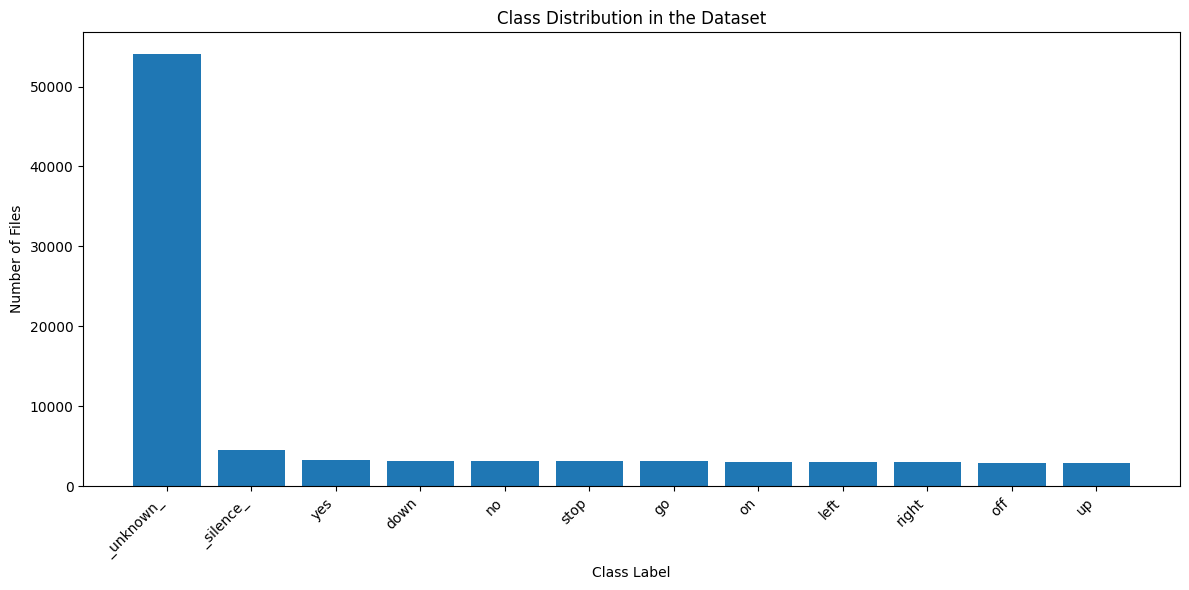

In [7]:
class_counts_train = count_classes(train_dir)
plot_class_counts(class_counts_train)

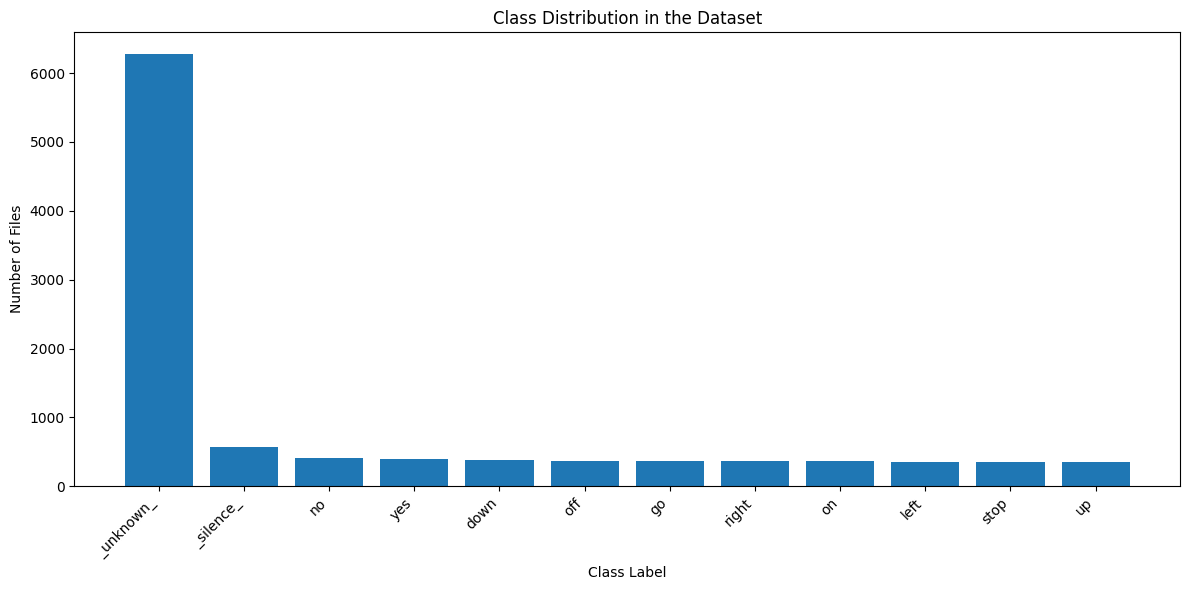

In [8]:
class_counts_val = count_classes(val_dir)
plot_class_counts(class_counts_val)

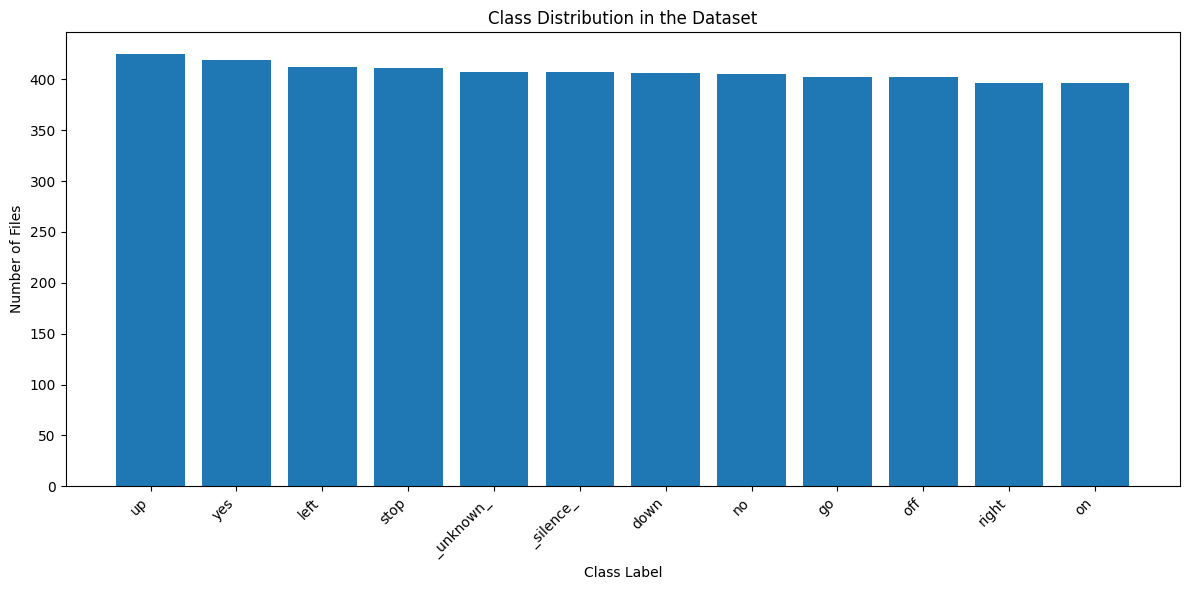

In [9]:
class_counts_test = count_classes(test_dir)
plot_class_counts(class_counts_test)

### ~Balanced data using bash script
- It is used only for AutoEncoder-SVM model. For more details, please see the corresponding part of the notebook.

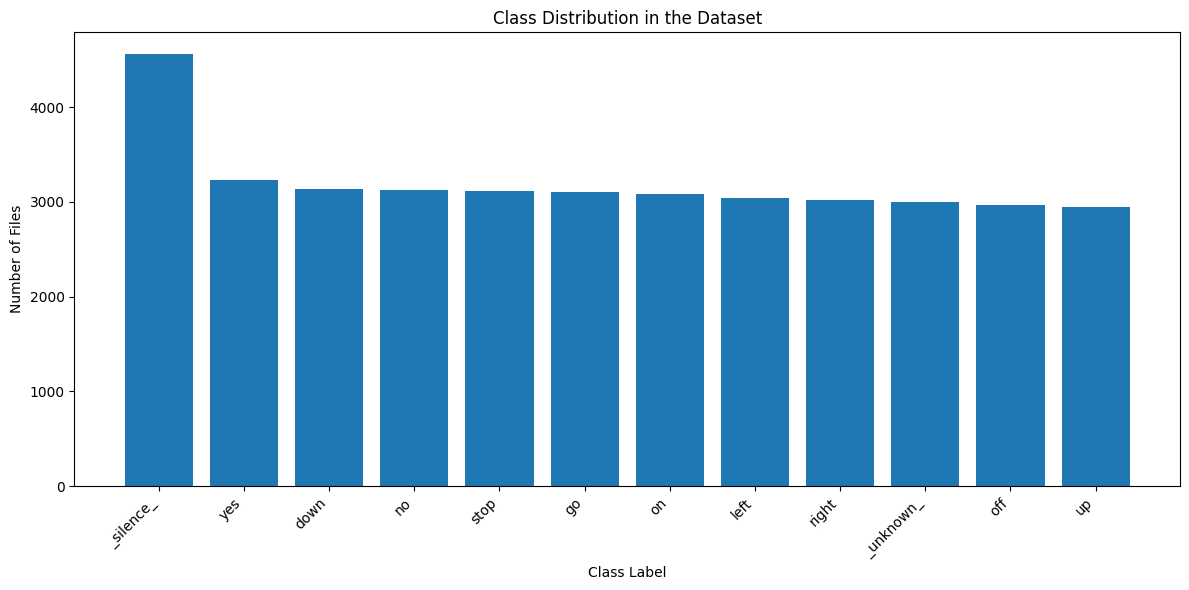

In [84]:
class_counts_train = count_classes(train_dir)
plot_class_counts(class_counts_train)

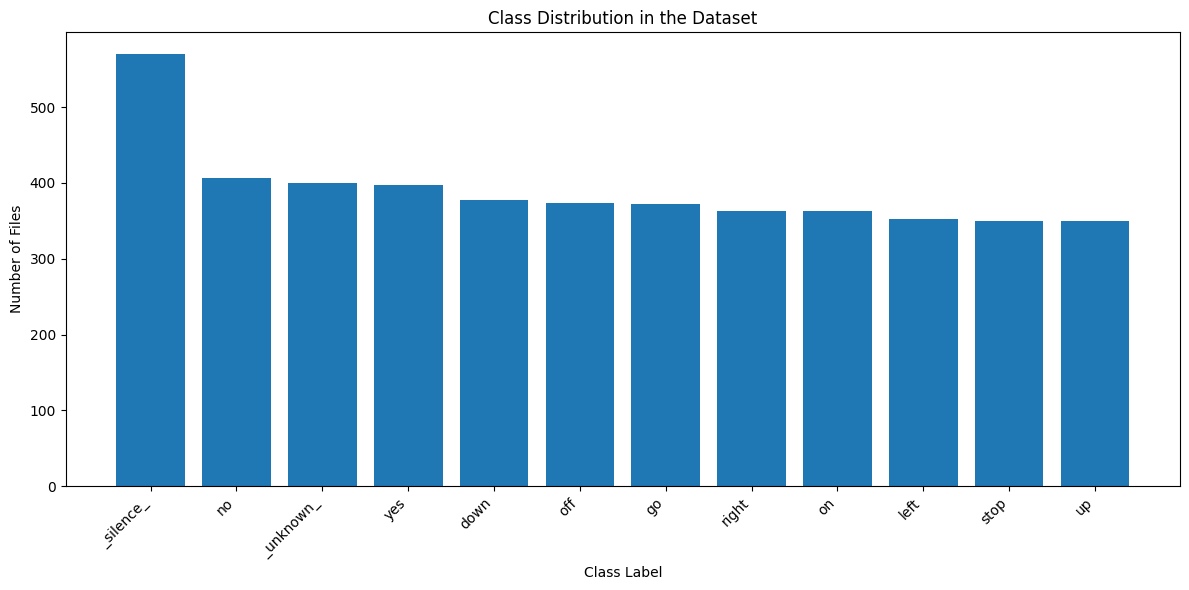

In [85]:
class_counts_val = count_classes(val_dir)
plot_class_counts(class_counts_val)

## Data processing:


### Enhance audio quality

Below functions are provided
- Remove reverberation
- Noise reduction with spectral subtraction (effective for reducing background noise)
- Noise reduction with simple thresholding (for reducing sudden spikes or bursts of noise)

They are not applied for our training because they require sufficient amount of investigation on the audios in order to find the right targets actually need corresponding enhancements. The parameters below are fairly good on the audios with low quality but they are tend to worsen the good quality audios as well. This is why, after with enough investigation, they will surely improve the results of the given task.

In [17]:
def apply_reverberation_removal(audio):
    # Convert EagerTensor to NumPy array
    if not isinstance(audio, np.ndarray):
        audio = audio.numpy()

    # Apply simple reverberation removal using a decay factor (adjust as needed)
    reverberation_removed_audio = librosa.effects.preemphasis(audio, coef=0.97)
    return reverberation_removed_audio
# Audio files recorded in environments with excessive reverberation or 
# echo may degrade the quality of speech signals, leading to reduced keyword spotting performance.

In [18]:
def spectral_subtraction_noise_reduction(audio, noise_level=0.02):

    if not isinstance(audio, np.ndarray):
        audio = audio.numpy()

    stft = librosa.stft(audio)

    # Compute magnitude spectrogram
    magnitude = np.abs(stft)

    # Estimate noise level
    noise = np.mean(magnitude[:, :int(magnitude.shape[1] * noise_level)], axis=1)

    # Apply spectral subtraction
    magnitude_denoised = np.maximum(magnitude - noise[:, np.newaxis], 0)

    # Reconstruct audio signal from denoised magnitude spectrogram
    denoised_audio = librosa.istft(magnitude_denoised * np.exp(1j * np.angle(stft)))

    return denoised_audio

# A common technique for removing stationary noise from audio signals 
# by estimating and subtracting the noise spectrum from the original signal's spectrum. 
# This method is effective for reducing background noise such as humming or constant hissing.

In [19]:
def simple_thresholding_noise_reduction(audio):

    if not isinstance(audio, np.ndarray):
        audio = audio.numpy()

    noisy_segments = librosa.effects.split(audio, top_db=20)
    noise_reduced_audio = librosa.effects.remix(audio, intervals=noisy_segments)

    # sf.write(output_filepath, noise_reduced_audio, sr)
    return noise_reduced_audio

# This method identifies segments of the audio that are considered "noisy" based on 
# a specified threshold and then reduces the amplitude of these segments. 
# This approach may work well for reducing sudden spikes or bursts of noise in the audio signal.

### Feature extraction

- compute_mfcc:

    -   Trimming
    -   Convert to melspectogram
    -   Convert to log scale (dB)
    -   Normalize
    -   Calculating the mffcs 
    -   Calculate the delta
    
- normalize_input_size:

    -   Ensure the crop of the block of size 101 mffcs for each input

In [44]:
def compute_mfcc(audio_file):
    """Return shape: [n_mfcc, time]"""
    
    audio_file, index = librosa.effects.trim(audio_file,
                                             hop_length=frame_hop_samples,
                                             frame_length=frame_length_samples)

    if not isinstance(audio_file, np.ndarray):
        audio_file = audio_file.numpy()
    y = librosa.feature.melspectrogram(y=audio_file, sr=SAMPLE_RATE, 
                                        hop_length=frame_hop_samples,
                                        n_fft=frame_length_samples,
                                        n_mels=128)

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(y)
    log_S_normalized = librosa.util.normalize(log_S)

    mfccs = librosa.feature.mfcc(
        S=log_S_normalized,
        # y=audio_file,
        sr=SAMPLE_RATE,
        n_mfcc=N_MELS,
        hop_length=frame_hop_samples,
        n_fft=frame_length_samples
    )
    
    delta_mfcc = librosa.feature.delta(mfccs)

    return delta_mfcc

In [45]:
def normalize_input_size(data, center_crop=False, target_size=101):
# this function is designed for a batch of mfccs which should be 3D
    if len(data.shape) == 3:
        batch_size, n_mels, N = data.shape

        if N == target_size:
            return data

        if N < target_size:
            tot_pads = target_size - N
            left_pads = int(np.ceil(tot_pads / 2))
            right_pads = int(np.floor(tot_pads / 2))
            return np.pad(data, [(0, 0), (0, 0), (left_pads, right_pads)], mode='constant')

        if center_crop:
            from_ = int((N / 2) - (target_size / 2))
        else:
            from_ = np.random.randint(0, np.floor(N - target_size))
        to_ = from_ + target_size

        return data[:, :, from_:to_]

    else:
        raise ValueError("Unsupported shape: {}".format(data.shape))


In [46]:
def compute_mfcc_wrapper(audio_file):
    return tf.numpy_function(compute_mfcc, [audio_file], tf.float32)

# when using tf.data.Dataset.map, TensorFlow switches to a graph mode for efficiency,
# but TensorFlow operations that are not directly compatible with graph mode.
# By using tf.numpy_function, 
# we were able to execute the original compute_mfcc function within the TensorFlow graph context 
# without encountering AutoGraph issues

def normalize_input_size_wrapper(audio_file, center_crop=False):
    return tf.numpy_function(normalize_input_size, [audio_file, center_crop], tf.float32)

def clean_ds_wrapper(audio_file):

    cleaned_audio = tf.numpy_function(librosa.util.normalize, [audio_file], tf.float32)
    cleaned_audio = tf.numpy_function(spectral_subtraction_noise_reduction, [cleaned_audio], tf.float32)
    cleaned_audio = tf.numpy_function(apply_reverberation_removal, [cleaned_audio], tf.float32)
    cleaned_audio = tf.numpy_function(simple_thresholding_noise_reduction, [cleaned_audio], tf.float32)
    cleaned_audio = tf.numpy_function(librosa.util.normalize, [cleaned_audio], tf.float32)
    
    # Convert the result to TensorFlow tensor
    return cleaned_audio

## Dataset object
- Generate a tf.data.Dataset from audio files in a directory.
- The dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis.

In [47]:
BATCH_SIZE = 64
train_dir = Path(os.path.join(DATA_DIR, 'train_data'))
test_dir = Path(os.path.join(DATA_DIR, 'test_data'))
val_dir = Path(os.path.join(DATA_DIR, 'validation_data'))


In [48]:
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_dir,
    # labels="inferred", ##directory structure
    batch_size=BATCH_SIZE,
    shuffle=True,
    sampling_rate=16000)
    # output_sequence_length=16000)

val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=val_dir,
    # labels="inferred", ##directory structure
    batch_size=BATCH_SIZE,
    shuffle=False,
    sampling_rate=16000)
    # output_sequence_length=16000)

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_dir,
    # labels="inferred", ##directory structure
    batch_size=BATCH_SIZE,
    shuffle=False,
    sampling_rate=16000)
    # output_sequence_length=16000)


label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 38329 files belonging to 12 classes.
Found 4673 files belonging to 12 classes.
Found 4888 files belonging to 12 classes.

label names: ['_silence_' '_unknown_' 'down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop'
 'up' 'yes']


In [49]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

### Audio Analysis: Feature Extraction and Visualization
- Visualize the mfcc map of the entire signal, map with colorbar and crop after input normalization. Also print some info about audio

In [38]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Label: yes
Waveform shape: (16000,)
MFCCs shape: (40, 101)
Audio playback


After applying:
	normalization,
	simple_thresholding_noise_reduction,
	apply_reverberation_removal,
	spectral_subtraction_noise_reduction
	and again normalization
Waveform shape: (15872,)
MFCCs shape: (40, 100)
Audio playback


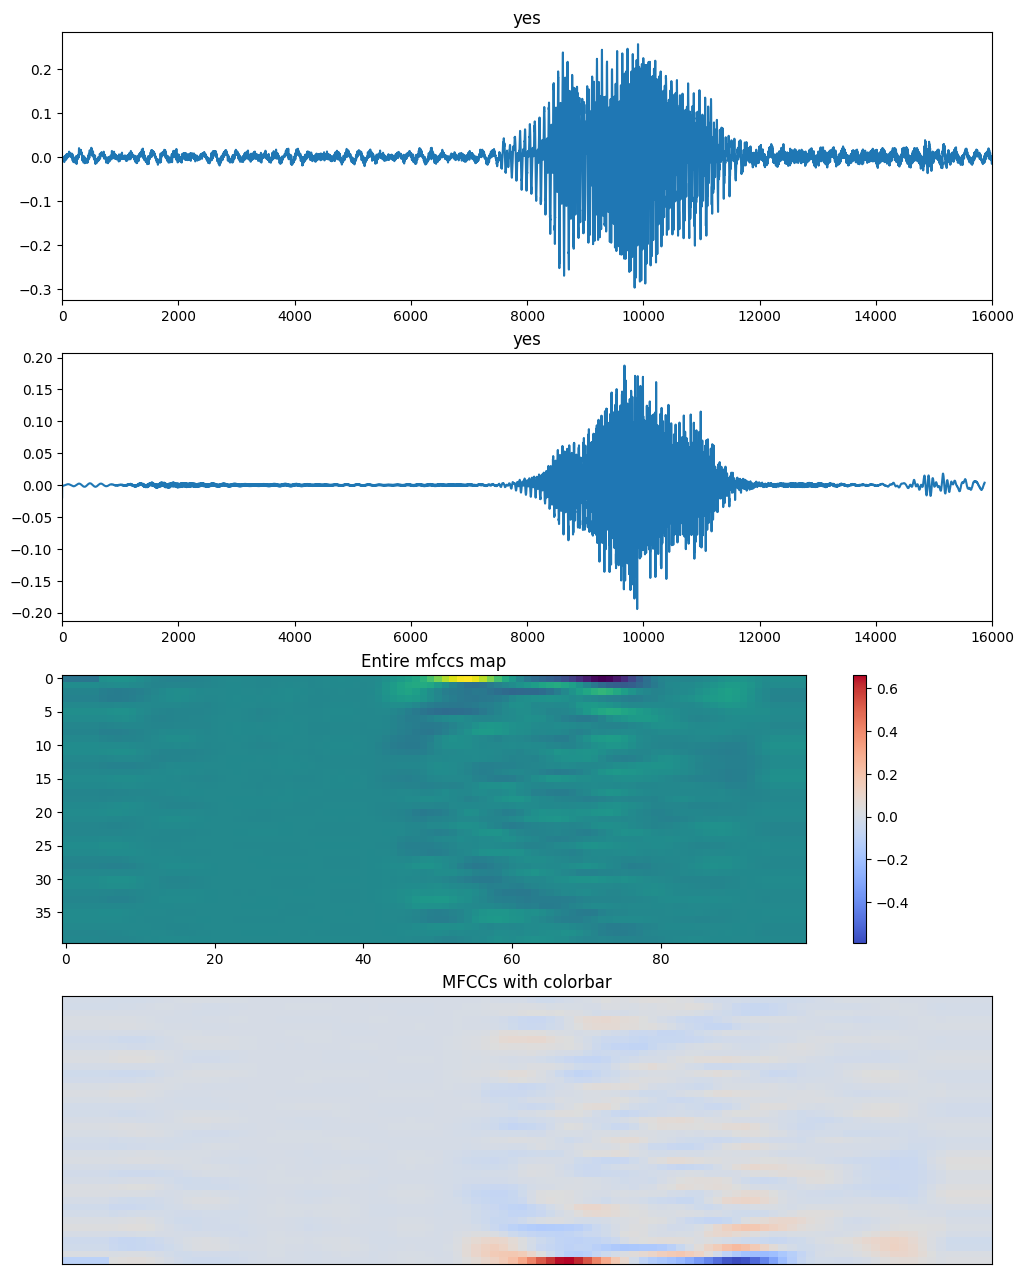

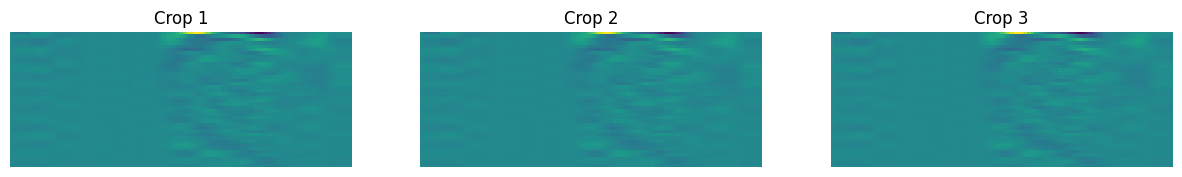

In [39]:
number = 20
audio_signal = example_audio[number]
label = label_names[example_labels[number]]

fig, axes = plt.subplots(4, figsize=(12, 16))
timescale = np.arange(audio_signal.shape[0])
mfccs = compute_mfcc(example_audio)

mfcc = mfccs[number]
print('Label:', label)
print('Waveform shape:', audio_signal.shape)
print('MFCCs shape:', mfcc.shape)
print('Audio playback')
display.display(display.Audio(audio_signal, rate=16000))

example_audio_normalized = librosa.util.normalize(example_audio)

new_example_audio = simple_thresholding_noise_reduction(apply_reverberation_removal(spectral_subtraction_noise_reduction(example_audio_normalized)))
audio_signal_new = new_example_audio[number]
mfccs = compute_mfcc(new_example_audio)
mfcc = mfccs[number]
audio_signal_new_normalized = librosa.util.normalize(audio_signal_new)

print('After applying:\n'
      '\tnormalization,\n' 
      '\tsimple_thresholding_noise_reduction,\n' 
      '\tapply_reverberation_removal,\n' 
      '\tspectral_subtraction_noise_reduction\n'
      '\tand again normalization')

print('Waveform shape:', audio_signal_new_normalized.shape)
print('MFCCs shape:', mfcc.shape)
print('Audio playback')
display.display(display.Audio(audio_signal_new_normalized, rate=16000))


# Plot Waveform
axes[0].plot(timescale, audio_signal)
axes[0].set_title(label)
axes[0].set_xlim([0, 16000])

axes[1].plot(np.arange(audio_signal_new.shape[0]), audio_signal_new)
axes[1].set_title(label)
axes[1].set_xlim([0, 16000])

# Plot Entire MFCCs map
axes[2].imshow(mfcc, aspect='auto') 
axes[2].set_title('Entire mfccs map')

# Plot MFCCs with colorbar
img = librosa.display.specshow(mfcc, sr=SAMPLE_RATE, hop_length=frame_hop_samples, n_fft=frame_length_samples) 

plt.colorbar(img, ax=axes[2])
axes[3].set_title('MFCCs with colorbar')

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))


for i in range(3):
    crop_of_example_batch = normalize_input_size(mfccs, center_crop=False) 
    axes[i].imshow(crop_of_example_batch[number])
    axes[i].set_title('Crop {}'.format(i + 1))
    axes[i].axis('off')  # turn off axis for cleaner display

plt.show()

### Adjust Dataset
- Functions to map the data processing
- Adjust the dataset object with applying: computing mfccs, cache, shuffle, repeat, map normalize input size, correct input shape, prefetch

In [50]:
# Condition is if the label is 0 (_silence_ class) then do not apply
def clean_ds(ds):
    return ds.map(
        map_func=lambda audio, label: tf.cond(
            tf.reduce_all(tf.equal(label, 0)),
            lambda: (clean_ds_wrapper(audio), label),
            lambda: (audio, label)
        ),
        num_parallel_calls=tf.data.AUTOTUNE)


In [51]:
def make_mfccs_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (compute_mfcc_wrapper(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)


In [52]:
def make_normalize_input_size_ds(ds, center_crop = False):
    return ds.map(
        map_func=lambda audio,label: (normalize_input_size_wrapper(audio, center_crop), label),
        num_parallel_calls=tf.data.AUTOTUNE)


In [53]:
def adjust_dataset(dataset, center_crop, shuffle, cache_file=None, repeat=False):

    # dataset = clean_ds(dataset)
    dataset = make_mfccs_ds(dataset)
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(10000)

    # Repeat the dataset indefinitely
    if repeat:
        dataset = dataset.repeat()
        
    if center_crop:
        dataset = make_normalize_input_size_ds(dataset, center_crop)
    else:
        dataset = make_normalize_input_size_ds(dataset)

    # Correct input shape for the network
    py_func = lambda data, label: (tf.numpy_function(tf.transpose, [data, [0, 2, 1]], tf.float32),label)
    dataset = dataset.map(py_func, num_parallel_calls=tf.data.AUTOTUNE)
 

    # Prefetch
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [54]:
train_dataset = adjust_dataset(train_ds,
                               center_crop=False, 
                               shuffle=True,
                               cache_file='train_cache',
                               repeat=True)

val_dataset = adjust_dataset(val_ds,
                             center_crop=True, 
                             shuffle=False,
                             cache_file='val_cache',
                             repeat=True)

test_dataset = adjust_dataset(test_ds,
                             center_crop=True, 
                             shuffle=False,
                             cache_file='test_cache')

train_steps = int(np.ceil(len(train_ds)))
val_steps = int(np.ceil(len(val_ds)))
test_steps = int(np.ceil(len(test_ds)))

# Training Models

## Class weights 
- Calculate the class_weights in order to deal with the highly imbalanced data

In [55]:
y_labels_of_train_ds = np.concatenate(list(train_ds.map(lambda s,lab: lab)), axis=0)

class_weights = class_weight.compute_class_weight('balanced'
                                               ,classes=np.unique(y_labels_of_train_ds)
                                               ,y=y_labels_of_train_ds)
class_weights_dict = dict(enumerate(class_weights))

In [57]:
class_weights_dict = {0: 1.6338267543859648,
 1: 0.1377787846284721,
 2: 2.3772335673261007,
 3: 2.3986638763683192,
 4: 2.4531610141587095,
 5: 2.3802715654952076,
 6: 2.5085016835016836,
 7: 2.4142093324692158,
 8: 2.4677873468035774,
 9: 2.3948087431693987,
 10: 2.52722184531886,
 11: 2.3080080545229245}

In [64]:
class_weights_dict

{0: 1.6338267543859648,
 1: 0.1377787846284721,
 2: 2.3772335673261007,
 3: 2.3986638763683192,
 4: 2.4531610141587095,
 5: 2.3802715654952076,
 6: 2.5085016835016836,
 7: 2.4142093324692158,
 8: 2.4677873468035774,
 9: 2.3948087431693987,
 10: 2.52722184531886,
 11: 2.3080080545229245}

## Cnn model

### Expand dimension

    For our Cnn model we need to have input shape of (None, 101, 40, 1) where None is the batch_size therefore we will expand the data dimension

In [58]:
def expand_data_dimension(dataset):
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, -1), label), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [59]:
train_dataset = expand_data_dimension(train_dataset)
val_dataset = expand_data_dimension(val_dataset)
test_dataset = expand_data_dimension(test_dataset)

### Architecture

In [60]:
def CnnModel(input_shape=(101, 40, 1), num_labels=len(keywords)):
    X_input = tf.keras.Input(input_shape)

    X = tf.keras.layers.Conv2D(32, (20, 8), activation='relu', name='conv2_0')(X_input)
    X = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X = tf.keras.layers.Conv2D(64, (10, 6), activation='relu', name='conv2_1')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X = tf.keras.layers.Conv2D(128, (5, 3), activation='relu', name='conv2_2')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(num_labels, activation='softmax', name='final_fc_sigmoid')(X)

    model = tf.keras.Model(inputs=X_input, outputs=X, name='CnnModel')
    
    return model

In [61]:
cnn_model = CnnModel()
cnn_model.summary()

Model: "CnnModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 101, 40, 1)]      0         
                                                                 
 conv2_0 (Conv2D)            (None, 82, 33, 32)        5152      
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 16, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 41, 16, 32)        128       
 Normalization)                                                  
                                                                 
 conv2_1 (Conv2D)            (None, 32, 11, 64)        122944    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 5, 64)         0  

### Train

In [62]:
model = cnn_model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [32]:
EPOCHS = 30
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    class_weight = class_weights_dict,
    epochs=EPOCHS,
    validation_steps=val_steps,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
)


Epoch 1/30


/Users/elnur/Desktop/HDA/venv-metal/lib/python3.8/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-02-08 11:54:54.728410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-08 11:54:54.825583: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1397/1397 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.6773

2024-02-08 11:56:22.983271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1397/1397 [==============================] - 94s 61ms/step - loss: 0.6532 - accuracy: 0.6773 - val_loss: 0.4991 - val_accuracy: 0.8377
Epoch 2/30
1397/1397 [==============================] - 84s 60ms/step - loss: 0.2844 - accuracy: 0.8362 - val_loss: 0.3826 - val_accuracy: 0.8807
Epoch 3/30
1397/1397 [==============================] - 83s 60ms/step - loss: 0.2064 - accuracy: 0.8714 - val_loss: 0.5338 - val_accuracy: 0.8349
Epoch 4/30
1397/1397 [==============================] - 82s 59ms/step - loss: 0.1628 - accuracy: 0.8923 - val_loss: 0.3512 - val_accuracy: 0.8949
Epoch 5/30
1397/1397 [==============================] - 82s 59ms/step - loss: 0.1361 - accuracy: 0.9058 - val_loss: 0.4788 - val_accuracy: 0.8538
Epoch 6/30
1397/1397 [==============================] - 83s 60ms/step - loss: 0.1092 - accuracy: 0.9184 - val_loss: 0.2618 - val_accuracy: 0.9300
Epoch 7/30
1397/1397 [==============================] - 83s 60ms/step - loss: 0.0906 - accuracy: 0.9280 - val_loss: 0.2761 - val_accura

### Plots: Loss and Accuracy

Text(0, 0.5, 'Accuracy [%]')

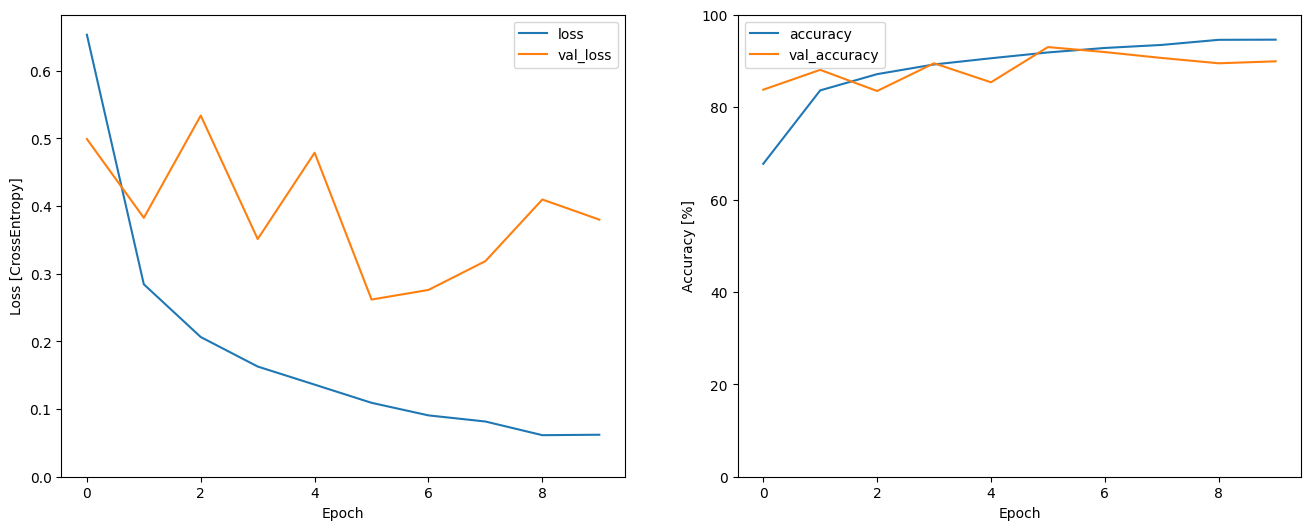

In [33]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Test

 5/77 [>.............................] - ETA: 1s 

2024-02-08 12:09:59.704572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 2s 17ms/step
#### VALIDATION PERFORMANCE
Top-One error accuracy: 91.76%
Precision (TP/(FP+TP)) (fraction of Keywords classified that are actually True): 92.09%
Recall (TP/(FN+TP)) (fraction of Keywords correctly classified): 91.75%
Fscore (harmonic mean of precision and recall): 91.80%


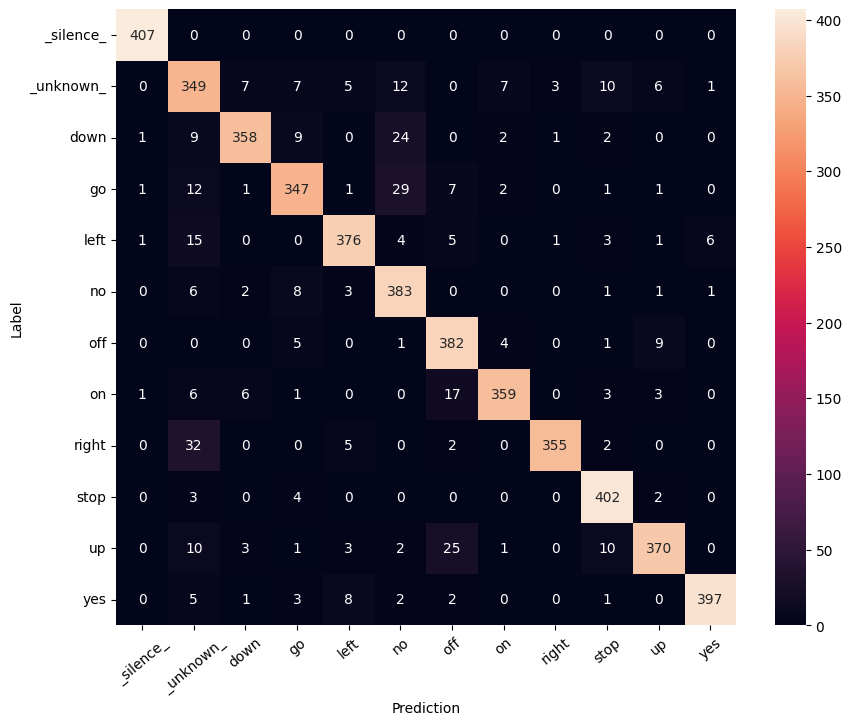

In [34]:
model.evaluate(test_dataset, return_dict=True)
test_preds = model.predict(test_dataset, steps=test_steps)
y_pred = test_preds.argmax(axis=-1)
y_true = tf.concat(list(test_dataset.map(lambda s,lab: lab)), axis=0)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, fscore, _= precision_recall_fscore_support(y_true, y_pred, average=None)
print('#### VALIDATION PERFORMANCE')
print('Top-One error accuracy: {:.2f}%'.format(accuracy*100))


total_precision = sum(precision) / len(keywords)
total_recall = sum(recall) / len(keywords)
total_fscore = sum(fscore) / len(keywords)


## precision and recall 
print('Precision (TP/(FP+TP)) (fraction of Keywords classified that are actually True): {:.2f}%'.format(total_precision*100))
print('Recall (TP/(FN+TP)) (fraction of Keywords correctly classified): {:.2f}%'.format(total_recall*100))
print('Fscore (harmonic mean of precision and recall): {:.2f}%'.format(total_fscore*100))



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.xticks(rotation = 40)
plt.show()


### Save the model

In [65]:
# Save the model
model.save('CnnModel.h5')


/Users/elnur/Desktop/HDA/venv-metal/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Crnn model

### Architecture

In [37]:
def CrnnModel(input_shape = (101, 40), num_labels=len(keywords)):
    
    X_input = tf.keras.Input(input_shape)

    X = tf.keras.layers.Conv1D(32, 20, strides=1, activation='relu', name='conv0')(X_input)
    X = tf.keras.layers.MaxPooling1D(pool_size=2)(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X = tf.keras.layers.Conv1D(64, 10, strides=1, activation='relu', name='conv1')(X)
    X = tf.keras.layers.MaxPooling1D(pool_size=2)(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X = tf.keras.layers.Conv1D(128, 5, strides=1, activation='relu', name='conv2')(X)
    X = tf.keras.layers.MaxPooling1D(pool_size=2)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X = tf.keras.layers.Conv1D(256, 3, strides=1, activation='relu', name='conv3')(X)
    X = tf.keras.layers.MaxPooling1D(pool_size=2)(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X = tf.keras.layers.GRU(128, return_sequences=True, name='gru0')(X)

    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(num_labels, activation='softmax', name='fc')(X)

    model = tf.keras.Model(inputs = X_input, outputs = X, name='CrnnModel')
    
    return model

In [38]:
crnn_model = CrnnModel()
crnn_model.summary()

Model: "CrnnModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 101, 40)]         0         
                                                                 
 conv0 (Conv1D)              (None, 82, 32)            25632     
                                                                 
 max_pooling1d (MaxPooling1  (None, 41, 32)            0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 41, 32)            128       
 Normalization)                                                  
                                                                 
 conv1 (Conv1D)              (None, 32, 64)            20544     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 16, 64)            0 

### Train

In [30]:
model = crnn_model

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [31]:
EPOCHS = 30
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    class_weight = class_weights_dict,
    epochs=EPOCHS,
    validation_steps=val_steps,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
)


Epoch 1/30


/Users/elnur/Desktop/HDA/venv-metal/lib/python3.8/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-02-08 10:16:49.099782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-08 10:16:49.451823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2024-02-08 10:16:55.401684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-08 10:16:56.570230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1397/1397 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.6953

2024-02-08 10:18:47.840681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-08 10:18:48.295550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1397/1397 [==============================] - 126s 82ms/step - loss: 0.5636 - accuracy: 0.6953 - val_loss: 0.6494 - val_accuracy: 0.7736
Epoch 2/30
1397/1397 [==============================] - 116s 83ms/step - loss: 0.2955 - accuracy: 0.8233 - val_loss: 0.5647 - val_accuracy: 0.8103
Epoch 3/30
1397/1397 [==============================] - 116s 83ms/step - loss: 0.2309 - accuracy: 0.8573 - val_loss: 0.4186 - val_accuracy: 0.8614
Epoch 4/30
1397/1397 [==============================] - 113s 81ms/step - loss: 0.1914 - accuracy: 0.8750 - val_loss: 0.3694 - val_accuracy: 0.8791
Epoch 5/30
1397/1397 [==============================] - 115s 83ms/step - loss: 0.1626 - accuracy: 0.8906 - val_loss: 0.4401 - val_accuracy: 0.8627
Epoch 6/30
1397/1397 [==============================] - 115s 82ms/step - loss: 0.1369 - accuracy: 0.9029 - val_loss: 0.3338 - val_accuracy: 0.8907
Epoch 7/30
1397/1397 [==============================] - 116s 83ms/step - loss: 0.1188 - accuracy: 0.9097 - val_loss: 0.3298 - val

### Plots: Loss and Accuracy

Text(0, 0.5, 'Accuracy [%]')

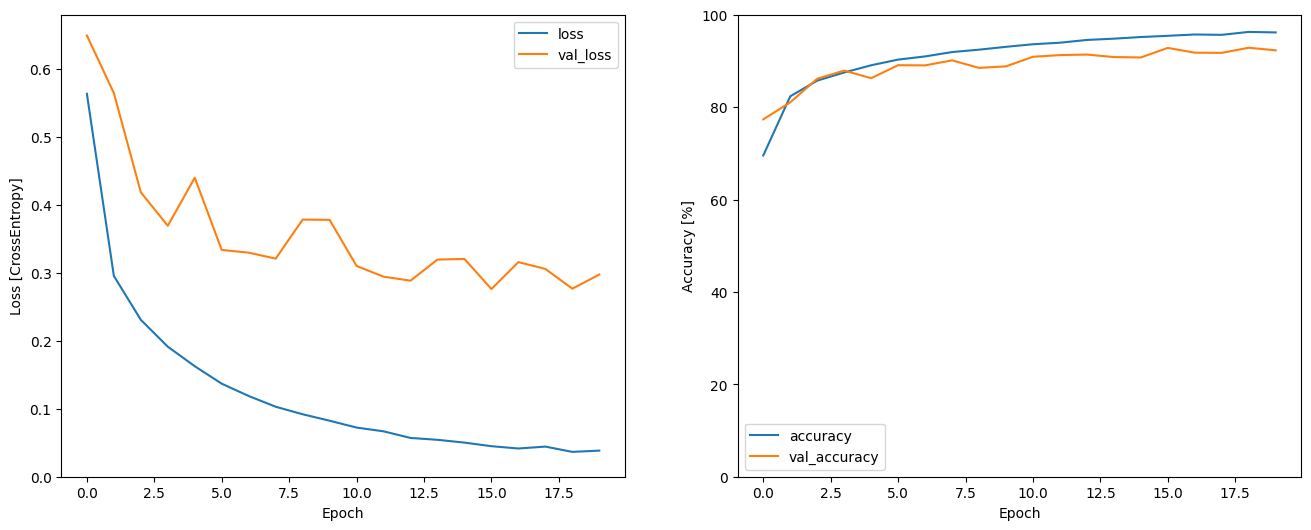

In [32]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Test

77/77 [==============================] - 2s 21ms/step
#### VALIDATION PERFORMANCE
Top-One error accuracy: 92.39%
Precision (TP/(FP+TP)) (fraction of Keywords classified that are actually True): 93.03%
Recall (TP/(FN+TP)) (fraction of Keywords correctly classified): 92.37%
Fscore (harmonic mean of precision and recall): 92.55%


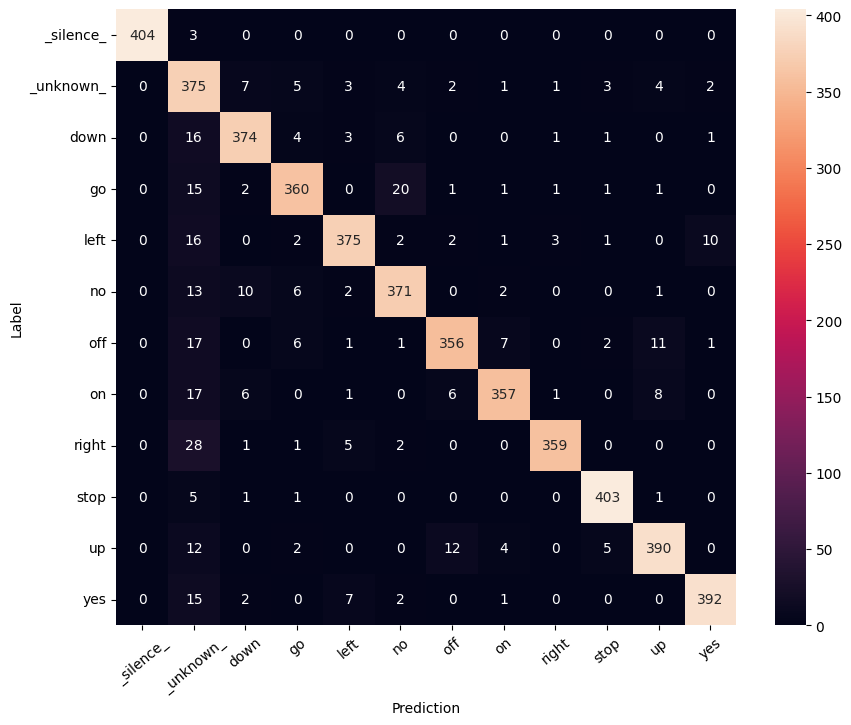

In [35]:
model.evaluate(test_dataset, return_dict=True)
test_preds = model.predict(test_dataset, steps=test_steps)
y_pred = test_preds.argmax(axis=-1)
y_true = tf.concat(list(test_dataset.map(lambda s,lab: lab)), axis=0)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, fscore, _= precision_recall_fscore_support(y_true, y_pred, average=None)
print('#### VALIDATION PERFORMANCE')
print('Top-One error accuracy: {:.2f}%'.format(accuracy*100))


total_precision = sum(precision) / len(keywords)
total_recall = sum(recall) / len(keywords)
total_fscore = sum(fscore) / len(keywords)


## precision and recall 
print('Precision (TP/(FP+TP)) (fraction of Keywords classified that are actually True): {:.2f}%'.format(total_precision*100))
print('Recall (TP/(FN+TP)) (fraction of Keywords correctly classified): {:.2f}%'.format(total_recall*100))
print('Fscore (harmonic mean of precision and recall): {:.2f}%'.format(total_fscore*100))



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.xticks(rotation = 40)
plt.show()


## Autoencoder-SVM model

### Autoencoder 

#### Expand dimension
- Input shoul be 4dim just like CNN model needs.

In [ ]:
def expand_data_dimension(dataset):
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, -1), label), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_dataset = expand_data_dimension(train_dataset)
val_dataset = expand_data_dimension(val_dataset)
test_dataset = expand_data_dimension(test_dataset)

#### Architecture

In [107]:
def build_deep_autoencoder(code_size, input_shape=(101, 40, 1)):

    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(input_shape))

    encoder.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Flatten())
    encoder.add(layers.Dropout(0.2))
    encoder.add(layers.Dense(code_size))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))


    decoder.add(layers.Dense(26 * 10 * 128, activation='elu'))
    decoder.add(layers.Reshape((26, 10, 128)))

    decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    decoder.add(layers.Cropping2D(cropping=((0, 1), (0, 0))))

    decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    decoder.add(layers.Cropping2D(cropping=((0, 1), (0, 0))))

    # Adjusting Conv2DTranspose layer to output the desired shape directly
    decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), activation='sigmoid', padding='same'))
    
    return encoder, decoder



In [109]:
encoder, decoder = build_deep_autoencoder(code_size=128, input_shape=(101, 40, 1))
encoder.summary()
decoder.summary()

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_109 (Conv2D)         (None, 101, 40, 32)       320       
                                                                 
 max_pooling2d_109 (MaxPool  (None, 51, 20, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_110 (Conv2D)         (None, 51, 20, 64)        18496     
                                                                 
 max_pooling2d_110 (MaxPool  (None, 26, 10, 64)        0         


 ing2D)                                                          
                                                                 
 flatten_44 (Flatten)        (None, 16640)             0         
                                                                 
 dropout_16 (Dropout)        (None, 16640)             0         
                                                                 
 dense_88 (Dense)            (None, 128)               2130048   
                                                                 
Total params: 2148864 (8.20 MB)
Trainable params: 2148864 (8.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 33280)             4293120   
                                                                 
 reshape_44 (Re

#### Bottleneck tests for architecture

In [108]:
Input_shape = (101, 40, 1)

# check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1, 8, 32, 128, 512]:
    encoder, decoder = build_deep_autoencoder(code_size=code_size, input_shape=Input_shape)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:] == (code_size,), "encoder must output a code of required size"
    assert decoder.output_shape[1:] == Input_shape, "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights) >= 6, "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights) >= 6, "decoder must contain at least 3 layers"

    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)" % (
        layer.name, get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


#### Prepare the data for Autoencoder

In [131]:
# As we  use data for AE without its actual labels, we extract static data with caching
# so that we can extract the train_vectors(latent vectors for training data) and 
# have their actual labels in order to be able to use for SVM input

get_labels = lambda data, label : label
leave_data_without_label = lambda data, label : data

tr_ds_svm = train_dataset.take(train_steps).cache('static_tr_balanced_cache')
labels_of_train = tr_ds_svm.map(get_labels, num_parallel_calls=tf.data.AUTOTUNE)
labels_of_train = np.concatenate(list(labels_of_train.as_numpy_iterator()), axis=0)
train_data_without_label = tr_ds_svm.map(leave_data_without_label, num_parallel_calls=tf.data.AUTOTUNE)

test_ds_svm = test_dataset.take(test_steps)
labels_of_test = test_ds_svm.map(get_labels, num_parallel_calls=tf.data.AUTOTUNE)
labels_of_test = np.concatenate(list(labels_of_test.as_numpy_iterator()), axis=0)
test_data_without_label = test_ds_svm.map(leave_data_without_label, num_parallel_calls=tf.data.AUTOTUNE)

val_ds_svm = val_dataset.take(val_steps)
labels_of_val = val_ds_svm.map(get_labels, num_parallel_calls=tf.data.AUTOTUNE)
labels_of_val = np.concatenate(list(labels_of_val.as_numpy_iterator()), axis=0)
val_data_without_label = val_ds_svm.map(leave_data_without_label, num_parallel_calls=tf.data.AUTOTUNE)

In [132]:
make_data_for_autoencoder = lambda data, label  : (data, data)

autoencoder_train_ds = train_dataset.map(make_data_for_autoencoder, num_parallel_calls=tf.data.AUTOTUNE)
autoencoder_val_ds = val_dataset.map(make_data_for_autoencoder, num_parallel_calls=tf.data.AUTOTUNE)
autoencoder_test_ds = test_dataset.map(make_data_for_autoencoder, num_parallel_calls=tf.data.AUTOTUNE)

#### Train

In [129]:
inp = tf.keras.Input(Input_shape)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [130]:
model_filename = 'autoencoder_network_balanced.hdf5'
last_finished_epoch = None


In [114]:
history = autoencoder.fit(autoencoder_train_ds,
                          epochs=50,
                          steps_per_epoch=train_steps,
                          validation_data=autoencoder_val_ds,
                          validation_steps=val_steps,
                          callbacks=[keras_utils.ModelSaveCallback(model_filename),
                                    tf.keras.callbacks.EarlyStopping(patience=3)],
                          verbose=2, initial_epoch=last_finished_epoch or 0)

Epoch 1/50


2024-02-17 14:31:16.638102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-17 14:33:42.875824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 0 - Model saved in autoencoder_network_balanced.hdf5
599/599 - 154s - loss: 0.0050 - val_loss: 0.0020 - 154s/epoch - 257ms/step
Epoch 2/50
Epoch 1 - Model saved in autoencoder_network_balanced.hdf5
599/599 - 144s - loss: 0.0021 - val_loss: 0.0020 - 144s/epoch - 241ms/step
Epoch 3/50
Epoch 2 - Model saved in autoencoder_network_balanced.hdf5
599/599 - 143s - loss: 0.0020 - val_loss: 0.0020 - 143s/epoch - 239ms/step
Epoch 4/50
Epoch 3 - Model saved in autoencoder_network_balanced.hdf5
599/599 - 141s - loss: 0.0020 - val_loss: 0.0020 - 141s/epoch - 236ms/step
Epoch 5/50
Epoch 4 - Model saved in autoencoder_network_balanced.hdf5
599/599 - 141s - loss: 0.0020 - val_loss: 0.0020 - 141s/epoch - 236ms/step
Epoch 6/50
Epoch 5 - Model saved in autoencoder_network_balanced.hdf5
599/599 - 140s - loss: 0.0018 - val_loss: 0.0015 - 140s/epoch - 233ms/step
Epoch 7/50
Epoch 6 - Model saved in autoencoder_network_balanced.hdf5
599/599 - 140s - loss: 0.0014 - val_loss: 0.0013 - 140s/epoch - 234ms/s

#### Test/Save the model

In [115]:
reconstruction_mse = autoencoder.evaluate(autoencoder_test_ds, steps=test_steps, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)


Convolutional autoencoder MSE: 0.0010440351907163858


In [122]:
encoder.save_weights("encoder_balanced.h5")
decoder.save_weights("decoder_balanced.h5")

#### Load/Test the model

In [ ]:
## should  not run right after saving weights (above cell)
encoder, decoder = build_deep_autoencoder(code_size=128, input_shape=(101, 40, 1))
encoder.load_weights("encoder_balanced.h5")
decoder.load_weights("decoder_balanced.h5")

inp = tf.keras.Input(Input_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

reconstruction_mse = autoencoder.evaluate(autoencoder_test_ds, steps=test_steps, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)

#### Extract the latent vectors (features)

In [116]:
train_vectors = encoder.predict(train_data_without_label)#, steps= train_steps)
test_vectors = encoder.predict(test_data_without_label)#, steps= test_steps)
val_vectors = encoder.predict(val_data_without_label)#, steps= test_steps)

2024-02-17 16:21:00.672764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 2s 24ms/step


#### Visualize original vs reconstracted image

In [117]:
reconstruction_test = decoder(test_vectors)
test_data_without_label_np = np.concatenate(list(test_data_without_label.as_numpy_iterator()), axis=0)
original_data = tf.squeeze(test_data_without_label_np[33])
reconstruction_test_data = tf.squeeze(reconstruction_test[33])

Text(0.5, 1.0, 'Reconstruction')

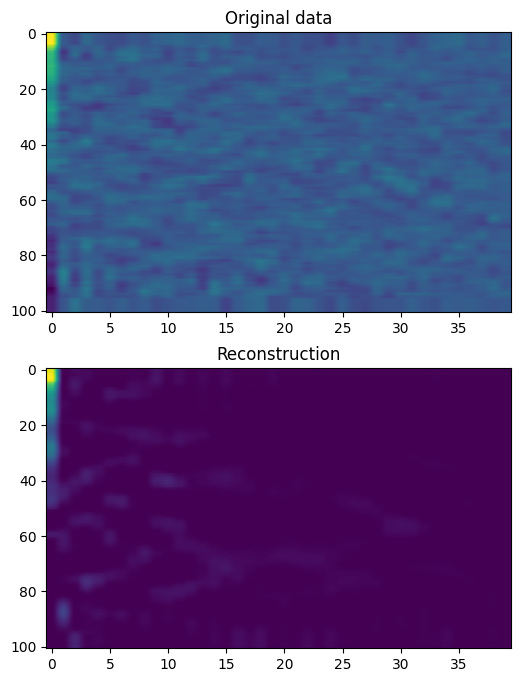

In [121]:
fig, axes = plt.subplots(2, figsize=(6, 8))

axes[0].imshow(original_data, aspect='auto') 
axes[0].set_title('Original data')

axes[1].imshow(reconstruction_test_data, aspect='auto') 
axes[1].set_title('Reconstruction')



### SVM

- As AE doesn't perform well with imbalanced data, I decided to balance the data itself with just reducing the majority class with bash script. However, if there was a built-in method(such as class_weights) to give the same importance in AE then it would perform way better. I couldn't find any such method, but I found some papers about class-sensitive VAE which can be applied and it would easily outperform this model and probably also other models mentioned before.

- When AE is trained with imbalance data, using Data Sampling techniques (oversampling,undersampling or combination of them) doesn't really help much, some of them even worsen the result. However, when AE trained on the whole imbalanced data, using SMOTEENN improved the result from ~65% to ~78% in test accuracy and also ~10% improvement on f1 score. Unfortunately, it still doesn't solve the bias against _unknown_ class though.

-   Data Sampling methods still left below just part of research but they are not used for theresults (of SVM) we see as outputs

#### Some Data Sampling methods

In [102]:
from collections import Counter
from imblearn.over_sampling import SMOTE
counter = Counter(labels_of_val)
print ('Before', counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
val_vectors_sm, labels_of_val_sm = smt.fit_resample(val_vectors, labels_of_val)
counter = Counter(labels_of_val_sm)
print('After', counter)

Before Counter({1: 6278, 0: 570, 5: 406, 11: 397, 2: 377, 6: 373, 3: 372, 7: 363, 8: 363, 4: 352, 9: 350, 10: 350})
After Counter({0: 6278, 1: 6278, 2: 6278, 3: 6278, 4: 6278, 5: 6278, 6: 6278, 7: 6278, 8: 6278, 9: 6278, 10: 6278, 11: 6278})


In [108]:
from imblearn.over_sampling import ADASYN
counter = Counter(labels_of_val)
print ('Before', counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
val_vectors_ada, labels_of_val_ada = ada.fit_resample(val_vectors, labels_of_val)
counter = Counter (labels_of_val_ada)
print ('After', counter)

Before Counter({1: 6278, 0: 570, 5: 406, 11: 397, 2: 377, 6: 373, 3: 372, 7: 363, 8: 363, 4: 352, 9: 350, 10: 350})
After Counter({10: 6329, 4: 6314, 11: 6313, 5: 6310, 8: 6295, 9: 6287, 1: 6278, 2: 6277, 0: 6274, 3: 6253, 6: 6248, 7: 6247})


In [ ]:
from imblearn.combine import SMOTETomek
counter = Counter (labels_of_val)
print('Before', counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
val_vectors_smtom, labels_of_val_smtom = smtom.fit_resample(val_vectors, labels_of_val)
counter = Counter (labels_of_val_smtom)
print('After', counter)

In [31]:
from collections import Counter
from imblearn.combine import SMOTEENN
counter = Counter(labels_of_train)
print('Before', counter)
# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
train_vectors_smenn, labels_of_train_smenn = smenn.fit_resample(train_vectors, labels_of_train)
# val_vectors_smenn, labels_of_val_smenn = smenn.fit_resample(val_vectors, labels_of_val)
counter = Counter(labels_of_train_smenn)
print ('After', counter)

Before Counter({1: 54074, 0: 4560, 11: 3228, 2: 3134, 5: 3130, 9: 3111, 3: 3106, 7: 3086, 4: 3037, 8: 3019, 6: 2970, 10: 2948})
After Counter({0: 54071, 10: 54048, 5: 54039, 6: 54038, 11: 54037, 3: 54036, 9: 54036, 8: 54033, 2: 54032, 4: 54032, 7: 54010, 1: 30853})


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
counter = Counter(labels_of_train)
print('Before', counter)
rus = RandomUnderSampler(random_state=0)
train_vectors_rus, labels_of_train_rus = rus.fit_resample(train_vectors, labels_of_train)
counter = Counter(labels_of_train_rus)
print('After', counter)

#### Finding best parameters

- Apply GridSearch on the small proportion of the train data in order to find the best performing parameters.

In [55]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV


In [56]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(class_weight = 'balanced'), param_grid, refit = True, verbose = 3) 
grid.fit(train_vectors[:10000], labels_of_train[:10000])


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.080 total time=   6.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.080 total time=   6.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.080 total time=   6.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.077 total time=   6.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.077 total time=   6.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.080 total time=   7.7s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.080 total time=   7.8s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.080 total time=   7.9s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.077 total time=   9.9s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.077 total time=   8.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.163 total time=   8.5s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

#### Fit/Test model with the best parameter
- Fit the model and predict on train/val/test vectors and print classification reports

In [124]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our SVM model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

clf = grid.best_estimator_
clf.fit(train_vectors, labels_of_train)

pred = clf.predict(train_vectors)
print(classification_report(labels_of_train, pred)) 

pred = clf.predict(val_vectors)
print(classification_report(labels_of_val, pred)) 

pred = clf.predict(test_vectors)
print(classification_report(labels_of_test, pred)) 

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1, class_weight='balanced', gamma=0.001)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4560
           1       0.97      0.94      0.96      3000
           2       0.98      0.97      0.97      3134
           3       0.97      0.96      0.97      3106
           4       0.97      0.98      0.97      3037
           5       0.96      0.97      0.97      3130
           6       0.95      0.97      0.96      2970
           7       0.98      0.96      0.97      3086
           8       1.00      0.97      0.99      3019
           9       1.00      0.97      0.98      3111
          10       0.94      0.97      0.95      2948
          11       0.99      0.98      0.99      3228

    accuracy                           0.97     38329
   macro avg       0.97      0.97      0.97     38329
weighted avg       0.97      0.97      0.97     38329

              precision    recall  f1-score 

#### Confusion Matrix of the result

#### VALIDATION PERFORMANCE
Top-One error accuracy: 83.16%
Precision (TP/(FP+TP)) (fraction of Keywords classified that are actually True): 83.75%
Recall (TP/(FN+TP)) (fraction of Keywords correctly classified): 83.13%
Fscore (harmonic mean of precision and recall): 83.30%


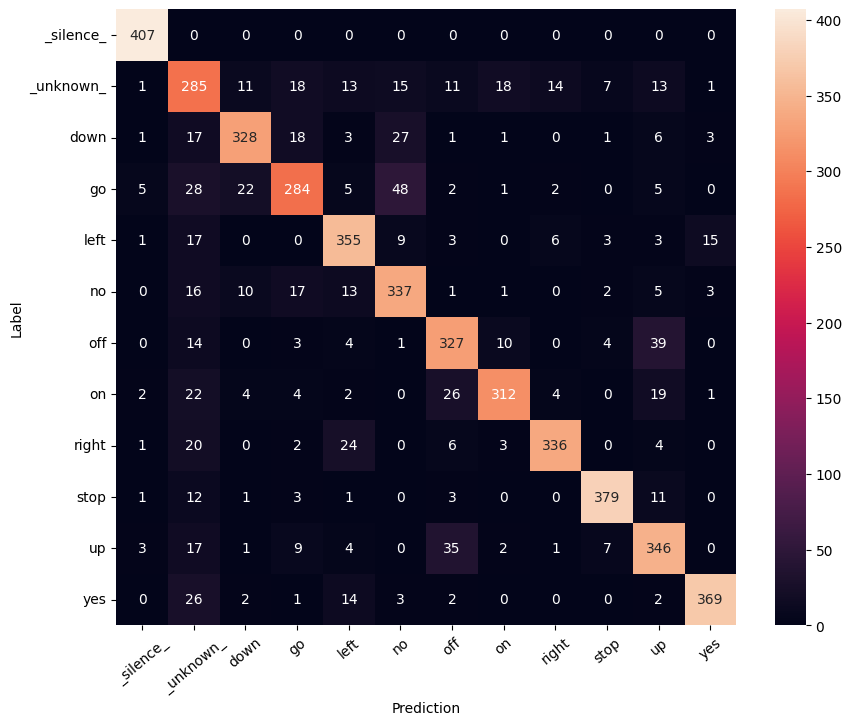

In [125]:
accuracy = accuracy_score(labels_of_test, pred)
precision, recall, fscore, _= precision_recall_fscore_support(labels_of_test, pred, average=None)
print('#### VALIDATION PERFORMANCE')
print('Top-One error accuracy: {:.2f}%'.format(accuracy*100))


total_precision = sum(precision) / len(keywords)
total_recall = sum(recall) / len(keywords)
total_fscore = sum(fscore) / len(keywords)


## precision and recall 
print('Precision (TP/(FP+TP)) (fraction of Keywords classified that are actually True): {:.2f}%'.format(total_precision*100))
print('Recall (TP/(FN+TP)) (fraction of Keywords correctly classified): {:.2f}%'.format(total_recall*100))
print('Fscore (harmonic mean of precision and recall): {:.2f}%'.format(total_fscore*100))



confusion_mtx = tf.math.confusion_matrix(labels_of_test, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.xticks(rotation = 40)
plt.show()
